In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

## Imports for Tweet Text Cleaning Pipeline

import preprocessor as p
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

import string
string.punctuation

### WordCloud
from wordcloud import WordCloud


# LDA Implementation by Gensim

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel

# LDA visualizations
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data = pd.read_csv('data/russia_201901_1_tweets_csv_hashed.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_text', 'tweet_time',
       'tweet_client_name', 'in_reply_to_tweetid', 'in_reply_to_userid',
       'quoted_tweet_tweetid', 'is_retweet', 'retweet_userid',
       'retweet_tweetid', 'latitude', 'longitude', 'quote_count',
       'reply_count', 'like_count', 'retweet_count', 'hashtags', 'urls',
       'user_mentions', 'poll_choices'],
      dtype='object')

In [4]:
data.head(3)

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
0,507097592116035584,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,"New York, USA",Just another day on the job.,NaN,101,137,2013-08-26,...,absent,absent,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,634855237140873217,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,"New York, USA",3 years ... Hardcore twitter fanatic #My stor...,NaN,56,94,2015-03-12,...,absent,absent,0.0,0.0,0.0,0.0,[],[],[],NaN
2,679020335602122752,2980186012,Infidel II 🕋💣🕋💩,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,I believe that OUR COUNTRY needs to BAN ISLAM ...,NaN,8685,1451,2015-01-15,...,absent,absent,0.0,0.0,0.0,0.0,[IslamIsTheProblem],[],[PigeonToday],NaN


## First Final Subset 
### Taking this steps
1. Only columns that I am using. 
2. Time Subset 2014 - 2019
3. Tweets only. 
4. Only in English


In [5]:
# columns subset

data = data[['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_text', 'tweet_time', 'is_retweet']]

In [6]:
# time subset

data['tweet_time'] = pd.to_datetime(data['tweet_time'])
start_date = '2014-01-01'
end_date = '2018-11-06'
mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)
data_prime = data.loc[mask]

In [7]:
# tweets subset

tweets_mask = data_prime['is_retweet'] == False
tweets = data_prime[tweets_mask]

# English only. Will have to clean more as well

tweets_english = tweets[ tweets['account_language'] == 'en']
tweets_english.head(2)

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_text,tweet_time,is_retweet
1,634855237140873217,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,"New York, USA",3 years ... Hardcore twitter fanatic #My stor...,NaN,56,94,2015-03-12,en,Ashley Madison stats find New Orleans among th...,2015-08-21 22:30:00,False
18,587677880190050304,2980186012,Infidel II 🕋💣🕋💩,CathyTo47590555,USA #IslamIsTheProbem #WakeUp,I believe that OUR COUNTRY needs to BAN ISLAM ...,NaN,8685,1451,2015-01-15,en,http://t.co/n1XwCJhPR8,2015-04-13 18:04:00,False


In [8]:
len(tweets_english['userid'].unique())

331

#### Combining tweet text by user

In [9]:
users_tweets_series = tweets_english.groupby(['userid']).apply(lambda x:" ".join(x.tweet_text))
users_tweets = pd.DataFrame( users_tweets_series ).reset_index()
users_tweets.columns = ['userid', 'tweet_text']
users_tweets.head()

,userid,tweet_text
0,+1zrIfSEu5GaeTzWgVgrPS6MiddJ55u5JXI5vuGzUY=,UNESCO: Palmyra temple destruction a war crime...
1,+9JIfRUrH1ZK+6UXd9kovs87ugSJpXFs6lZsSG526Bw=,Googles (GOOGL) Self-Driving Cars to Hit AJust...
2,+OfqC132EuMruwHVYFJe74MjbhEX28BOiBY8vZK68o=,Courts in Russia: Savchuk won the case against...
3,+SA6zQByhddiKlCktA2rf8L2XYAirih0DZ6GJAa7m7A=,Trump Renews His Assault on Fox News Host Megy...
4,+cMaDi6JD3MhrhNUUwd6g4lCgZhH8UWs65fOHU4ItpE=,Do onto others as you'd have done to you ! htt...


**Tweet Text Cleaning Pipeline**

In [16]:
### Creating a function to clean_up the twitter_text
#### ALL WORKS!!!!



### Imports that are needed for cleaning text pipeline

import preprocessor as p
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

import string
string.punctuation

punct = set(string.punctuation)

punct.remove('@')
punct.remove('#')
punct.add('🇺🇸')
punct.add('🇯🇵')
punct.add('🇰🇷')
punct.add('🇩🇪')
punct.add('🇨🇳')
punct.add('🇫🇷')
punct.add('🇪🇸')
punct.add('🇮🇹')
punct.add('🇷🇺')
punct.add('🇬🇧')
punct.add('🤗')



### STOP WORDS 
stop_words = set(nltk.corpus.stopwords.words('english')) 


### Custom stop words. 
added_stop_words = {'rt', 'via', 'new', 'time', 'today', 'one', 'say', 'get', 'go', 
                      'im', 'know', 'need', 'made', 'https', 'http', 'that', 'would', 
                      'take', 'your', 'two', 'yes', 'back', 'look', 'see', 'amp', 'tell',
                      'give', 'httpst', 'htt', 'use', 'dont', 'thing', 'man', 'thank', 'lol', 'cc', 'didnt',
                      'hey', 'like', 'ask', 'let', 'even', 'also', 'ok', 'etc', 'thank', 'ive', 'hi', 'wasnt'}

### stemmer and lemmer

lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')


def preprocessing_text(text):
    '''
    INPUT: str
    OUTPUT: str w/ emojies, urls, hashtags and mentions removed
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.RESERVED, p.OPT.SMILEY)
    clean_text = p.clean(text)
    
    return clean_text

def remove_symbols(word, symbol_set):
    
    '''
    Removing symbols from word
    '''
    return ''.join(char for char in word 
                    if char not in symbol_set)


def clean_tweet_text(text_column):
    '''
    INPUT: 
    Pandas dataframe column w/tweets text: 
    OUTPUT: 
    Cleaned Docs, bag of words (bow)
    symbol_set charachters removed,
    specified stop words removed
    punctuation removed
    words stemmed and lemmatized
    non-english words removed
    words <3 chars removed
    
    
    '''
    
    
    # converting from pd to list
    corpus = text_column.values.tolist()
    
    #Removing all HTTPs
    docs_no_http = [ re.sub(r'https?:\/\/.*\/\w*', '', doc) for doc in corpus ]
    #First ---> tokenize docs
    tokenized_docs = [doc.split() for doc in docs_no_http]
    # Lower case words in doc
    tokenized_docs_lowered  = [[word.lower() for word in doc]
                                for doc in tokenized_docs]

    # Removing punctuation from docs
    docs_no_punct = [[remove_symbols(word, punct) for word in doc] 
                    for doc in tokenized_docs_lowered]

        
    docs_no_stops1 = [[word for word in doc if word not in added_stop_words] 
                     for doc in docs_no_punct]
    
    docs_no_stops = [[word for word in doc if word not in stop_words ] 
                     for doc in docs_no_stops1]
    # Lemmatize words in docs
    docs_lemmatized = [[lemmer.lemmatize(word) for word in doc]
                      for doc in docs_no_stops]
    
    # Stem words in docs
    docs_stemmed = [[stemmer.stem(word) for word in doc]
                      for doc in docs_lemmatized]
    
    # Removes mentions, emotions, hashtags and emojies
    docs_no_mentions = [preprocessing_text(' '.join(doc)) for doc in docs_stemmed]
    
    # Removes all non-english charachters and any other different charachter leftovers
    docs_english_only = [re.sub(r'[^a-zA-Z]', " ", doc) for doc in docs_no_mentions]
    
    # only words that are more than 2 chars long
    
    cleaned_docs = []
    for doc in docs_english_only:
        cleaned_docs.append(' '.join(word for word in doc.split() if len(word)>2))
        
    
    # converts into list of lists
    # bag of words per each doc
    bow = [list(tweet.split(' ')) for tweet in cleaned_docs]
    
   
    

    return cleaned_docs, bow 



In [26]:
# bow[:1]

In [17]:
cleaned_docs, bow = clean_tweet_text(users_tweets.tweet_text)

In [22]:
cleaned_docs[4:5]

['onto other youd done wish knew wouldnt crazi wonder love someon youll anyth warp invit imaginari friend threesom mirror mirror walldo christ fuck anymor hand air said forget']

In [28]:
len(cleaned_docs)

331

In [29]:
cleaned_docs[2:3]

['court russia savchuk case troll troll wont troll anyon due ludmila savchuk']

### First Visualization of all words in corpus

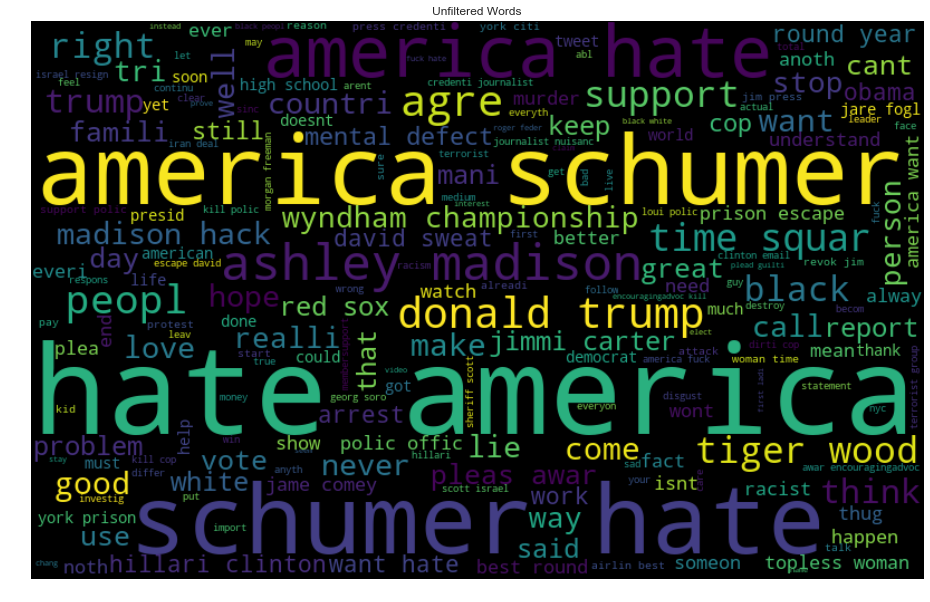

<Figure size 432x288 with 0 Axes>

In [56]:
all_words = ' '.join([text for text in cleaned_docs])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=200, stopwords = ['hey', 'lol', '[][]', 'cc', 'anyon', 'say', 'etc']).generate(all_words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear", cmap = 'inferno')
plt.axis('off')
plt.title('Unfiltered Words')
plt.show()
plt.savefig('plots/word_cloud.png')

In [31]:
# Create Dictionary
# <gensim.corpora.dictionary.Dictionary at 0x1a550e2518>
id2word = corpora.Dictionary(bow)

# Create Corpus
texts = bow


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [32]:
id2word

In [33]:
len(corpus)

331

In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
# Print the Keyword in the 7 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"" + 0.005*"milit" + 0.005*"follow" + 0.005*"arm" + 0.004*"syria" + '
  '0.004*"journalist" + 0.004*"interest" + 0.003*"syrian" + 0.003*"aleppo" + '
  '0.003*"reader"'),
 (1,
  '0.015*"west" + 0.009*"pillow" + 0.009*"car" + 0.009*"kany" + 0.008*"ran" + '
  '0.008*"fight" + 0.008*"point" + 0.008*"googl" + 0.007*"bouchard" + '
  '0.007*"obama"'),
 (2,
  '0.221*"america" + 0.219*"hate" + 0.125*"schumer" + 0.011*"want" + '
  '0.007*"comey" + 0.007*"fuck" + 0.006*"best" + 0.006*"trump" + 0.005*"jame" '
  '+ 0.004*"gender"'),
 (3,
  '0.014*"ashley" + 0.013*"madison" + 0.013*"trump" + 0.010*"wood" + '
  '0.010*"york" + 0.009*"time" + 0.009*"donald" + 0.008*"squar" + '
  '0.008*"tiger" + 0.007*"shoot"'),
 (4,
  '0.005*"azeri" + 0.004*"siz" + 0.003*"var" + 0.003*"bir" + 0.002*"siktir" + '
  '0.001*"harada" + 0.001*"alan" + 0.001*"ddind" + 0.001*"kimi" + '
  '0.001*"qnazik"'),
 (5,
  '0.012*"black" + 0.010*"agre" + 0.009*"support" + 0.007*"white" + '
  '0.007*"peopl" + 0.006*"trump

In [54]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bow, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)   


Perplexity:  -7.179941010138653

Coherence Score:  0.6990206623660175


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.003899 -0.176346       1        1  48.061687
3     -0.067650 -0.190568       2        1  29.929825
2     -0.362116  0.137194       3        1  15.601328
6      0.060177 -0.113274       4        1   3.922999
1      0.119523  0.086735       5        1   2.016196
0      0.127839  0.134084       6        1   0.313375
4      0.126126  0.122174       7        1   0.154591, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
1653  Default  8534.000000    america  8534.000000  30.0000  30.0000
1748  Default  8488.000000       hate  8488.000000  29.0000  29.0000
402   Default  4760.000000    schumer  4760.000000  28.0000  28.0000
333   Default  1046.000000      peopl  1046.000000  27.0000  27.0000
27    Default   989.000000     ashley   989.000000  26.0000  26.0000
284   Default   976.000000    madison   976.000000  25.0000  25.0000
356   Default   522.000000     presid   522.000000  24.0000  24.0000
526   Default   751.000000       wood   751.000000  23.0000  23.0000
783   Default   772.000000       make   772.000000  22.0000  22.0000
537   Default   745.000000       york   745.000000  21.0000  21.0000
852   Default   343.000000      point   343.000000  20.0000  20.0000
518   Default   226.000000       west   226.000000  19.0000  19.0000
1921  Default  1172.000000       agre  1172.000000  18.0000  18.0000
1191  Default   321.000000    countri   321.000000  17.0000  17.0000
507   Default  1119.000000       want  1119.000000  16.0000  16.0000
770   Default   487.000000        lie   487.000000  15.0000  15.0000
50    Default  1426.000000      black  1426.000000  14.0000  14.0000
436   Default   616.000000      squar   616.000000  13.0000  13.0000
319   Default   393.000000      obama   393.000000  12.0000  12.0000
101   Default   367.000000       come   367.000000  11.0000  11.0000
475   Default   575.000000      tiger   575.000000  10.0000  10.0000
142   Default   661.000000     donald   661.000000   9.0000   9.0000
971   Default   732.000000       vote   732.000000   8.0000   8.0000
810   Default   358.000000     murder   358.000000   7.0000   7.0000
691   Default   197.000000     follow   197.000000   6.0000   6.0000
476   Default   764.000000       time   764.000000   5.0000   5.0000
480   Default   496.000000    topless   496.000000   4.0000   4.0000
454   Default  1144.000000    support  1144.000000   3.0000   3.0000
519   Default   917.000000      white   917.000000   2.0000   2.0000
533   Default   460.000000    wyndham   460.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
4613   Topic7     0.288662        lub     1.018530   5.2113  -7.1750
4608   Topic7     0.288662        ldi     1.018530   5.2113  -7.1750
4644   Topic7     0.288662       rmaq     1.018530   5.2113  -7.1750
4569   Topic7     0.288662        edi     1.018530   5.2113  -7.1750
4622   Topic7     0.288662       nmaz     1.018530   5.2113  -7.1750
4606   Topic7     0.288662      lanet     1.018530   5.2113  -7.1750
4633   Topic7     0.288662    oyunlar     1.018530   5.2113  -7.1750
6138   Topic7     0.287828       ping     1.017974   5.2089  -7.1779
3771   Topic7     0.376140        ist     1.479557   5.1026  -6.9103
4562   Topic7     0.201179    deyilik     0.931047   4.9400  -7.5361
4572   Topic7     0.201179     edirik     0.931047   4.9400  -7.5361
4528   Topic7     0.463616       alan     2.198154   4.9158  -6.7012
4688   Topic7     0.201179       zlar     0.931047   4.9400  -7.5361
4557   Topic7     0.201179       daha     0.931047   4.9400  -7.5361
4575   Topic7     0.201179  etdiyiniz     0.931047   4.9400  -7.5361
4614   Topic7     0.201179       mane     0.931047   4.9400  -7.5361
4657   Topic7     0.201179        sik     0.931047   4.9400  -7.5361
4541   Topic7     0.2

In [ ]:
pyLDAvis.save_html(vis, 'lda.html')

## Interpretation of this plot
This visualization provides a **global view of the topics** and **how they differ** from each other while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic. 

Visualizations of topic model are usually a challenge since we are operating in multidimentional space. Documents (all tweets per user) are modeled as a mixture (probability distribution) of topics and topics themselves are modeled as distributions over terms (words/n-grams).

This visualization answers following questions: 

1. What is the meaning of each topic? 
* Answer to this questions can be derived from the right panel of this visualization: List of top 

Left part of visualization anwers following qiestions: We are observing topics as circles in two-dimensional plane whose centers are determined by computing the distance between topics that are scaled to project the intertopic distances onto two dimentions. 
2. How prevalent is each topic?
3. How do the topics relate to each other?
We are observing topics as circles in two-dimensional plane whose centers are determined by computing the distance between topics that are scaled to project the intertopic distances onto two dimentions.
** Area ** of the circle represents prevalence of the topic. The larger the area the more the prevalence. 

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bow, start=1, limit=30, step=1)

In [52]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.010*"" + 0.005*"milit" + 0.005*"follow" + 0.005*"arm" + 0.004*"syria" + '
  '0.004*"journalist" + 0.004*"interest" + 0.003*"syrian" + 0.003*"aleppo" + '
  '0.003*"reader"'),
 (1,
  '0.015*"west" + 0.009*"pillow" + 0.009*"car" + 0.009*"kany" + 0.008*"ran" + '
  '0.008*"fight" + 0.008*"point" + 0.008*"googl" + 0.007*"bouchard" + '
  '0.007*"obama"'),
 (2,
  '0.221*"america" + 0.219*"hate" + 0.125*"schumer" + 0.011*"want" + '
  '0.007*"comey" + 0.007*"fuck" + 0.006*"best" + 0.006*"trump" + 0.005*"jame" '
  '+ 0.004*"gender"'),
 (3,
  '0.014*"ashley" + 0.013*"madison" + 0.013*"trump" + 0.010*"wood" + '
  '0.010*"york" + 0.009*"time" + 0.009*"donald" + 0.008*"squar" + '
  '0.008*"tiger" + 0.007*"shoot"'),
 (4,
  '0.005*"azeri" + 0.004*"siz" + 0.003*"var" + 0.003*"bir" + 0.002*"siktir" + '
  '0.001*"harada" + 0.001*"alan" + 0.001*"ddind" + 0.001*"kimi" + '
  '0.001*"qnazik"'),
 (5,
  '0.012*"black" + 0.010*"agre" + 0.009*"support" + 0.007*"white" + '
  '0.007*"peopl" + 0.006*"trump

### Ploting Coherence Scores to Determine optimal numebr of topics

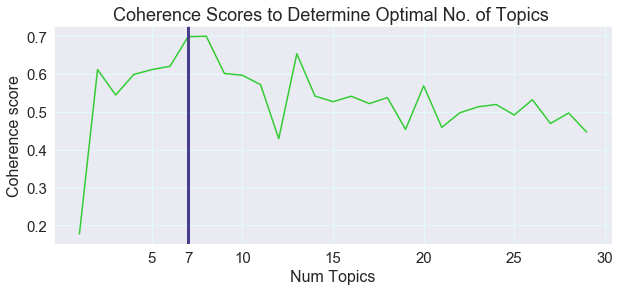

In [55]:
# Show graph

limit=30; start=1; step=1;

x = range(start, limit, step)

plt.figure(figsize=(10,4))

sns.set_style("darkgrid")

plt.plot(x, coherence_values, c = 'limegreen')
plt.xlabel("Num Topics", fontsize = 16)
plt.ylabel("Coherence score", fontsize = 16)


plt.xticks((5, 7, 10, 15, 20, 25, 30), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(c = 'lightcyan')

plt.axvline(x=7, c = 'darkslateblue', linewidth = 3.0)

plt.title('Coherence Scores to Determine Optimal No. of Topics ', fontsize = 18)
plt.savefig('plots/coherence_scores.png')
plt.show()

In [45]:
lda_model[corpus]

In [48]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(cleaned_docs)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=cleaned_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

IndexError: list index out of range